# Fourier Transform Modelling development
> A script for developing the functions needed to model the optical systems with Fourier Transforms and complex array phase pupils

In [215]:
import numpy as np
from scipy.ndimage import zoom
from tqdm import tqdm
import matplotlib.pyplot as plt
from formatter import *
from conversions import *

To Do:


## Current scripts

In [170]:
def FT_model_broadband(pupil, aperture, m2_obsc, chip_dim, wavels, weights, foc_length, pix_size, transform_size, q1, q2, polar=True, leakages=[]):
    """
    Models the PSF generated by a point source of light generated by the input phase pupil across a spectrum
    Works through repetative calls of FT_model
    
    Inputs:
        pupil: Phase pupil complex array 
        aperture: Telescope aperture diameter (m)
        m2_obsc: Aperture of central obscuration from the secondary mirror (m)
        chip dim: Units of pixels (int), this should be an even int to prevent rounding error
        wavels: Array of wavelengths (m)
        weights: Array of relative weights for each wavelength
        foc_lenght: Effective focal lenght of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
        transform_size: Size of the desired array to fourier transform(power of 2)
        q1, q2: coordinate specifying the positional offset from the normal of th telescope of the observed star
            if polar: polar coordinates - q1:r (arcseconds), q2:phi (radians)
            else: cartesian coordinates - q1:x (pixels), q2:y (pixels)
        leakages: an array of leakage per wavelength given as a float, ie 4% == 0.04 (%)
        
    Returns:
        Numpy array representing the normalised PSF as it appears on the detector
        
    """  
    im_out = np.zeros((chip_dim,chip_dim))
    if len(leakages) == 0:
        for wavel, weight in zip(wavels, weights):
            im_out += weight * FT_model(pupil, aperture, m2_obsc, chip_dim, wavel, foc_length, pix_size, transform_size, q1, q2, polar=polar, leakage=0.0)
    else:
        for wavel, weight, leakage in zip(wavels, weights, leakages):
            im_out += weight * FT_model(pupil, aperture, m2_obsc, chip_dim, wavel, foc_length, pix_size, transform_size, q1, q2, polar=polar, leakage=leakage)
    
    # Normalise
    PSF = im_out/np.sum(im_out)
    
    return PSF

In [171]:
def FT_model_binary(pupil, aperture, m2_obsc, chip_dim, wavels_2D, weights_2D, total_flux_2D, foc_length, pix_size, transform_size, q1_2D, q2_2D, polar=True, leakages_2D=[[],[]]):
    """
    Models two binary stars on a broadband spectrum using Fourier transforms
    Models the PSF generated by a point source of light generated by the input phase pupil across a spectrum
    Works through repetative calls of FT_model
    
    Inputs:
        pupil: Phase pupil complex array 
        aperture: Telescope aperture diameter (m)
        m2_obsc: Aperture of central obscuration from the secondary mirror (m)
        chip dim: Units of pixels (int), this should be an even int to prevent rounding error
        wavels_2D: 2D Array of wavelengths, one for each star (m)
        weights_2D: 2D Array of relative weights for each wavelength, one for each star
        total_flux_2D: total flux of each star, used to scale the final PSFs
        foc_lenght: Effective focal lenght of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
        transform_size: Size of the desired array to fourier transform(power of 2)
        q1_2D, q2_2D: 2 1D arrays of coordinates specifying the positional offset from the normal of th3 telescope of the observed star
            if polar: polar coordinates - q1:r (arcseconds), q2:phi (radians)
            else: cartesian coordinates - q1:x (pixels), q2:y (pixels)
        leakages_2D: an 2D array of leakage per wavelength given as a float, ie 4% == 0.04 (%), one for each star
        
    Sample inputs:
        wavels_2D = [[595e-9, 600e-9, 605e-9], [595e-9, 600e-9, 605e-9]]
        weights_2D = [[0.8, 0.9, 0.95], [0.6, 0.7, 0.8]]
        total_fluxes_2D = [1e10, 1e9]
        q1_2D = [0, 5]
        q2_2D = [0, 6]
            => translates to coordinates of (0,0) and (5,6)
        leakages_2D = [[0.01, 0.02, 0.02], [0.02, 0.03, 0.04]]
        
    Returns:
        Numpy array representing the normalised PSF as it appears on the detector
        
    """  
    
    PSF_out = np.zeros([chip_dim, chip_dim])
    for wavels, weights, total_flux, q1, q2, leakage in zip(wavels_2D, weights_2D, total_flux_2D, q1_2D, q2_2D, leakages_2D):
        PSF = FT_model_broadband(pupil, aperture, m2_obsc, chip_dim, wavels, weights, foc_length, pix_size, transform_size, q1, q2, polar=polar, leakages=leakage)
        
        # Add to output array
        PSF_out += PSF * total_flux
        
    # Normalise output array
    PSF_out = PSF_out/np.sum(PSF_out)
    
    return PSF_out

In [210]:
def FT_model(pupil, aperture, m2_obsc, chip_dim, wl, foc_length, pix_size, transform_size, q1, q2, polar=True, leakage=0.0):
    """
    Models the PSF generated by a point source of light generated by the input phase pupil
    
    Inputs:
        pupil: Phase pupil complex array 
        aperture: Telescope aperture diameter (m)
        m2_obsc: Aperture of central obscuration from the secondary mirror (m)
        chip dim: Units of pixels (int), this should be an even int to prevent rounding error
        wl: Wavelength (m)
        foc_lenght: Effective focal lenght of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
        transform_size: Size of the desired array to fourier transform(power of 2)
        q1, q2: coordinate specifying the positional offset from the normal of th telescope of the observed star
            if polar: polar coordinates - q1:r (arcseconds), q2:phi (radians)
            else: cartesian coordinates - q1:x (pixels), q2:y (pixels)
        leakage: Leakage term given as a float, ie 4% == 0.04 (%)
        
    Returns:
        Numpy array representing the normalised PSF as it appears on the detector        
    """ 
    # Caclaute how big the pupil array needs to be to get our desired Fourier Transformed array size
    plate_scale = pix_size/foc_length    # Radians per pixel
    spatial_freq = wl/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(transform_size/scale_factor)
    
    # Scale pupil 
    pupil_scaled = scale_pupil(pupil, size_out)
    
    # Convert the coordinates to polar if cartesian or convert r to radians for phase gradient functions
    if not polar:
        r = np.hypot(q1, q2) * plate_scale # radians
        phi = np.arctan2(q2, q1) # radians
    else:
        r = arcsec_to_rad(q1)
        phi = q2
     
    # Apply the phase gradient to the pupil
    pupil_new = apply_phase_gradient(pupil_scaled, aperture, wl, r, phi)
    
    # Apply the seconday mirror central obscuration and zero the power out of the apertrure
    radius = aperture/2
    radii_range = np.linspace(-radius, radius, num=size_out, endpoint=False)
    X,Y = np.meshgrid(radii_range, radii_range)
    R = np.hypot(X,Y)
    
    mag_array = np.ones(pupil_scaled.real.shape)
    mag_array[R > radius] = 0 
    mag_array[R < m2_obsc/2] = 0
    phase_array = np.angle(pupil_new)
    pupil_out = mag_array * np.exp(1j*phase_array)
    
    # Perform the FT
    array_out = np.zeros((transform_size,transform_size),dtype=complex)
    array_out[0:size_out, 0:size_out] = pupil_out
    im = np.fft.fftshift(np.abs(np.fft.fft2(array_out))**2)
    
    # Take the part that falls on the chip
    start = (transform_size-chip_dim)//2
    end = transform_size - (transform_size-chip_dim)//2
    im_out = im[start:end, start:end]
    
    # Generate an empty pupil
    empty_pupil = np.zeros((size_out, size_out), dtype=complex)
    C = np.linspace(-size_out//2, size_out//2, num=size_out, endpoint=False)
    X_empty, Y_empty = np.meshgrid(C, C)
    R_empty = np.hypot(X_empty, Y_empty)
    empty_pupil[R_empty < size_out//2] = np.complex(1, 0)
    
    # Apply the phase gradient across the empty pupil
    empty_pupil = apply_phase_empty(empty_pupil, aperture, wl, r, phi)
    
    # Apply the seconday mirror central obscuration and zero the power out of the apertrure
    mag_array = np.ones(empty_pupil.real.shape)
    mag_array[R > radius] = 0 
    mag_array[R < m2_obsc/2] = 0
    phase_array = np.angle(empty_pupil)
    empty_pupil_out = mag_array * np.exp(1j*phase_array)
    
    # Perform FT on empty pupil
    array_out_empty = np.zeros((transform_size,transform_size),dtype=complex)
    array_out_empty[0:size_out, 0:size_out] = empty_pupil_out
    im_empty = np.fft.fftshift(np.abs(np.fft.fft2(array_out_empty))**2)

    # Take the part that falls on the chip
    start = (transform_size-chip_dim)//2
    end = transform_size - (transform_size-chip_dim)//2
    im_out_empty = im_empty[start:end, start:end]
    
    # Normalise and sum 
    PSF = (1 - leakage) * im_out/np.sum(im_out)
    PSF_empty = leakage * im_out_empty/np.sum(im_out_empty)
    PSF_out = PSF + PSF_empty
    
    return PSF_out

(1994, 1994)


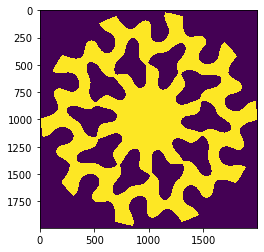

In [218]:
path = "/Users/louis/Projects/Toliman/Toliman_files/Pupils_fits/pupils/"

# pupil = np.load("/Users/louis/Projects/Toliman/Pupil_files/pupil_array.npy")
# plt.imshow(np.angle(pupil))

# psf = FT_model_binary(pupil_from_fits(path + "pupil_new_2k.fits"), 0.1, 0.0, 200, [[375e-9], [475e-9], [575e-9], [675e-9], [775e-9]], [[1], [1], [1], [1], [1]], [1, 1, 1, 1, 1], 3.625, 6.5e-6, 2**12, [-80,-40,0,40,80], [-80,-40,0,40,80], polar=False, leakages_2D=[[0.0], [0.05], [0.1], [0.15], [0.2]])
psf = FT_model_binary(pupil_from_fits(path + "pupil_new_2k.fits"), 0.018, 0.0, 200, [[375e-9], [475e-9], [575e-9], [675e-9], [775e-9]], [[1], [1], [1], [1], [1]], [1, 1, 1, 1, 1], 1.370, 7.4e-6, 2**12, [-80,-40,0,40,80], [-80,-40,0,40,80], polar=False, leakages_2D=[[0.0], [0.05], [0.1], [0.15], [0.2]])
plt.imshow(psf)
plt.colorbar()

In [98]:
# path = "/Users/louis/Projects/Toliman/"
# psf = FT_model_broadband(pupil_from_fits(path + "Toliman_files/Pupils_fits/pupils/pupil_new_2k.fits"), 0.1, 0.011, 200, [575e-9, 575e-9, 595e-9, 605e-9], [1, 1, 1, 1], 3.625, 6.5e-6, 2**12 , 0, 0, polar=True, leakages=[0.05, 0.05, 0.05, 0.05])
# plt.imshow(psf)
# plt.colorbar()

In [96]:
# pupil = pupil_from_fits(path + "Pupil_files/pupil_file.fits")
# plt.figure(figsize=(5,5))
# plt.imshow(np.angle(pupil))

In [97]:
# pupil_new = pupil_from_fits(path + "Toliman_files/Pupils_fits/pupils/pupil_new_2k.fits")
# plt.figure(figsize=(5,5))
# plt.imshow(np.angle(pupil_new))

In [33]:
def scale_pupil(pupil, output_size):
    """
    Takes in the complex pupil array and returns a scaled version
    
    Inputs:
        pupil: 2D Complex np array of the phase pupil
        output_size: Size of the pupil array to be returned
        
    Returns:
        pupil_scaled: 2D Complx np array of the pupil in the dimension of output_sizeXoutput_size
    """
    # Scale the real component of the pupil to this size
    size_in = pupil.shape[0]
    ratio = output_size/size_in    
    Re_scaled = zoom(pupil.real, ratio)
    
    # Zero the components outside of the aperture to zero
    c = output_size//2
    s = np.linspace(-c, c, num=output_size, endpoint=False)
    X,Y = np.meshgrid(s, s)
    R = np.hypot(X,Y)
    Re_scaled[R > c-1] = 0 
    # Note the -1 here is to account for rounding errors intoruced by interger divisions
    
    # Create the new pupil from a real and imaginary component
    pupil_scaled = Re_scaled + np.zeros([output_size, output_size]) * 1j
    
    return pupil_scaled

In [99]:
# psf = FT_model(pupil_from_fits("files/pupil_new_2k.fits"), 0.1, 0.011, 200, 595e-9, 3.625, 6.5e-6, 2**10 , 16.5, 0.01, polar=True)
# plt.imshow(psf)

In [35]:
def apply_phase_gradient(pupil, aperture, wavelength, r, phi):
    """
    Applies the change in phase across the pupil induced by an off centre star to the input binarised phase pupil
    
    Inputs:
        pupil: complex array representing the phase pupil
        aperture: Aperture of the telescope (m)
        wavelength: Wavelength to be modelled (m)
        r: radial offset from normal of telescope aperture in polar coordaintes (radians)
        phi: angular offset from the positive x plane (radians)
        
    Returns:
        Complex numpy array with the phase gradient for off-axis stars applied
    """
    if r == 0:
        return pupil
    
    phase = calculate_phase_gradient(pupil, aperture, wavelength, r, phi, shift=False)
    anti_phase = calculate_phase_gradient(pupil, aperture, wavelength, r, phi, shift=True)
    
    mask = np.angle(pupil) > 0
    inv_mask = -(mask - 1)
    
    selection1 = np.multiply(phase, inv_mask)
    selection2 = np.multiply(anti_phase, mask)
    aperture_phase = selection1 + selection2
    
    pupil_phase = np.exp(1j*aperture_phase)
    
    return pupil_phase

In [179]:
def apply_phase_empty(pupil, aperture, wavelength, r, phi):
    """
    Applies the change in phase across the pupil induced by an off centre star to an empty aperture
    
    Inputs:
        pupil: complex array representing the empty aperture
        aperture: Aperture of the telescope (m)
        wavelength: Wavelength to be modelled (m)
        r: radial offset from normal of telescope aperture in polar coordaintes (radians)
        phi: angular offset from the positive x plane (radians)
        
    Returns:
        Complex numpy array with the phase gradient for off-axis star applied
    """
    if r == 0:
        return pupil
    
    phase = calculate_phase_gradient(pupil, aperture, wavelength, r, phi, shift=False)
    mask = np.abs(pupil) > 0
    phase_mask = np.multiply(phase, mask)
    pupil_phase = np.exp(1j*phase_mask)
    
    return pupil_phase

In [180]:
def calculate_phase_gradient(pupil, aperture, wavelength, r, phi, shift=False):
    """
    Calculates the change in phase across the pupil induced by an off centre star
    
    Inputs:
        pupil: complex array representing the phase pupil
        aperture: Aperture of the telescope (m)
        wavelength: Wavelength to be modelled (m)
        r: radial offset from normal of telescope aperture in polar coordaintes (radians)
        phi: angular offset from the positive x plane (radians)
        
    Returns: numpy array of the phase change of the incident light across the pupil apertuere 
    """
    # Create an xy coordinate grid
    gridsize = pupil.shape[0]        
    Xs = np.linspace(-gridsize//2,(gridsize//2), num=gridsize, endpoint=False)
    X, Y = np.meshgrid(Xs, Xs)
    
    # Convert to polar coords
    R = np.hypot(X, Y)
    theta_array = np.arctan2(X, Y) 
    
    # Rotate the array by the phi offset
    theta_array_shifted = theta_array - phi 
    
    # Convert back to cartesian coordiantes for typical use
    y_new = R * np.sin(theta_array_shifted)

    # Calculate the scaling values from the wavelength and offset
    OPD = aperture*np.tan(r)
    cycles = OPD/wavelength
    period = gridsize/cycles
    
    # Phase shift for reccessed regions of pupil
    if shift:
        phase_shift = period/2
    else:
        # Note this may be redundant - it was introduced to curb introduced distortions which may have been from an earier bug
        phase_shift = period
        
    # Apply phase shift to array
    y_new += phase_shift
    
    # Scale phase change based on calculated scaling values
    phase_array = y_new * 2*np.pi/period
    
    return phase_array

## Development Area

In [7]:
wavelength  = 500e-9
aperture = 0.02 # m
focal_length = 0.15 # m

# CCD Architecture
detector_size = 256
detector_pitch = 1.12e-6

azimuthal_offset = 16.5

In [8]:
pupil_raw = pupil_from_fits("files/pupil_new_2k.fits")

In [9]:
new_pupils = []
num = 16
thetas = np.linspace(-np.pi, np.pi*(1-(1/num)), num=num)
for theta in tqdm(thetas):
    new_pupil = pupil_phase_driver(pupil_raw, aperture, wavelength, azimuthal_offset, theta)
    new_pupils.append(new_pupil)

100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


In [14]:
%%time
ims = []
for pupil in tqdm(new_pupils):
    im = model_FT(pupil, aperture, detector_size, wavelength, focal_length, detector_pitch)
    ims.append(im)

100%|██████████| 16/16 [00:54<00:00,  4.17s/it]

CPU times: user 1min 1s, sys: 17.1 s, total: 1min 18s
Wall time: 55.2 s


In [16]:
create_gif(ims, "asymmetry_test")

## Redundant scripts

In [6]:
def pupil_phase_driver(pupil, aperture, wavelength, azimuthal_offset, angular_offset):
    """
    Calculates the change in phase across the pupil induced by an off centre star
    pupil: complex array representing the phase pupil
    aperture: Aperture of the telescope (m)
    wavelength: Wavelength to be modelled (m)
    azimuthal_offset: Angle that is formed between the star being modelled and the normal of the telesope aperture (arcseconds)
    angular_offset: Angle around the circle formed by azimulath offset, 0 = offset in +x, pi/2 = offest in +y etc (radians)
    """
    if azimuthal_offset == 0:
        return pupil
    
    phase = pupil_phase_mask(pupil, aperture, wavelength, azimuthal_offset, angular_offset, shift=False)
    anti_phase = pupil_phase_mask(pupil, aperture, wavelength, azimuthal_offset, angular_offset, shift=True)
    
    mag_array = np.abs(pupil)
    mask = np.angle(pupil) > 0
    inv_mask = -(mask - 1)
    
    selection1 = np.multiply(phase, inv_mask)
    selection2 = np.multiply(anti_phase, mask)
    selection = selection1 + selection2
    
    aperture_phase = mag_array * selection
    new_pupil = mag_array * np.exp(1j*aperture_phase)
    
    return new_pupil

In [ ]:
def off_axis_FT(mask, aperture, chip_dim, wl, foc_length, pix_size, FT_size, binary_separation, field_angle):
    """
    Inputs:
        mask: Phase mask complex array 
        aperture: Telescope aperture diameter (m)
        chip dim: Units of pixels (int)
        wl: Wavelength (m)
        foc_lenght: Distance to focal plane of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
        FT_size: Size of the desired FT array
    """
    
    # Decompose mask into Re and Im for scaling
    Re = mask.real
    mask_size = mask.shape[0]
    
    # Caclaute hoew big the pupil array needs to be to get our desired Fourier Transformed array size
    plate_scale = pix_size / foc_length    # Radians per pixel
    spatial_freq = wl/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(FT_size/scale_factor)
    
    # Scale the real component of the pupil to this size
    size_in = mask_size
    ratio = size_out/size_in    
    Re_scaled = zoom(Re, ratio)
    
    # Zero the components outside of the aperture to zero
    c = size_out//2
    s = np.linspace(-c, c-1, num=size_out)
    X,Y = np.meshgrid(s, s)
    R = np.hypot(X,Y)
    Re_scaled[R > c-1] = 0 
    # Note the -1 here is to account for rounding errors intoruced by interger divisions
    
    # Create the new mask from a real and imaginary component
    mask_scaled = Re_scaled + np.zeros([size_out, size_out]) * 1j
    
    # Apply the phase gradient to the pupil
    off_axis_mask = pupil_phase_driver(mask_scaled, aperture, wl, binary_separation, field_angle)
    
    # Perform the FT
    array_out = np.zeros((FT_size,FT_size),dtype=complex)
    array_out[0:size_out, 0:size_out] = mask_scaled
    im = np.fft.fftshift(np.abs(np.fft.fft2(array_out))**2)
        
    # Take the part that falls on the chip
    # Note: This could intorduce some form of float error (ie returns a 9x9 instead of 10x10 array)
    start = (FT_size-chip_dim)//2
    end = FT_size - (FT_size-chip_dim)//2
    im_out = im[start:end, start:end]
    
    return im_out

In [12]:
# Non vectorised slow version of current scripts

def model_FT_old(mask, mask_size, chip_dim, wavels, foc_length, pix_size):
    """
    Redundant version, much slower use model_FT_monochromatic/broadband
    
    Inputs:
        mask: Phase mask complex array 
        mask_size: Size of the phase mask, ie the aperture diameter (m)
        chip dim: Units of num pixels
        wavels: Array of wavelengths (m)
        foc_lenght: Focal length of lens/distance to focal plane of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
    Note: Assumes all wavelengths have equal intesity (add intesities later)
    """
    grid_size = mask.shape[1]
    plate_scale = pix_size / foc_length    # Radians per pixel
    
    im_out = np.zeros((chip_dim,chip_dim))

    for wavel in wavels:
        spatial_freq = wavel/mask_size
        array_size = int(grid_size*spatial_freq/plate_scale)
        complex_array = np.array(np.zeros((array_size,array_size)),dtype=complex)
        complex_array[0:grid_size,0:grid_size] = mask
        im = np.fft.fftshift(np.abs(np.fft.fft2(complex_array))**2)
            
        # Vector or matrix operation
        # Scipy or numpy regridding
        for y in range(chip_dim):
            for x in range(chip_dim):
                # Split line below and multiply line below by some scale/ratio to normalise
                # Pass in all wavelengths across all bands together and sum then normalise to 1
                im_out[y][x] += im[int((array_size-chip_dim)/2) + y][int((array_size-chip_dim)/2) + x]

    return im_out

In [1]:
def model_FT_scaled(mask, aperture, chip_dim, wl, foc_length, pix_size, FT_size):
    """
    Inputs:
        mask: Phase mask complex array 
        aperture: Telescope aperture diameter (m)
        chip dim: Units of pixels (int)
        wl: Wavelength (m)
        foc_lenght: Distance to focal plane of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
        FT_size: Size of the desired FT array
    """
    
    # Decompose mask into Re and Im for scaling
    Re = mask.real
    mask_size = mask.shape[0]
    
    # Caclaute hoew big the pupil array needs to be to get our desired Fourier Transformed array size
    plate_scale = pix_size / foc_length    # Radians per pixel
    spatial_freq = wl/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(FT_size/scale_factor)
    
    # Scale the real component of the pupil to this size
    size_in = mask_size
    ratio = size_out/size_in    
    Re_scaled = zoom(Re, ratio)
    
    # Zero the components outside of the aperture to zero
    c = size_out//2
    s = np.linspace(-c, c-1, num=size_out)
    X,Y = np.meshgrid(s, s)
    R = np.hypot(X,Y)
    Re_scaled[R > c-1] = 0 
    # Note the -1 here is to account for rounding errors intoruced by interger divisions
    
    # Create the new mask from a real and imaginary component
    mask_scaled = Re_scaled + np.zeros([size_out, size_out]) * 1j
    
    # Perform the FT
    array_out = np.zeros((FT_size,FT_size),dtype=complex)
    array_out[0:size_out, 0:size_out] = mask_scaled
    im = np.fft.fftshift(np.abs(np.fft.fft2(array_out))**2)
        
    # Take the part that falls on the chip
    # Note: This could intorduce some form of float error (ie returns a 9x9 instead of 10x10 array)
    start = (FT_size-chip_dim)//2
    end = FT_size - (FT_size-chip_dim)//2
    im_out = im[start:end, start:end]
    
    return im_out

In [ ]:
def on_axis_FT(mask, aperture, chip_dim, wl, foc_length, pix_size, FT_size):
    """
    Inputs:
        mask: Phase mask complex array 
        aperture: Telescope aperture diameter (m)
        chip dim: Units of pixels (int)
        wl: Wavelength (m)
        foc_lenght: Distance to focal plane of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
        FT_size: Size of the desired FT array
    """
    
    # Decompose mask into Re and Im for scaling
    Re = mask.real
    mask_size = mask.shape[0]
    
    # Caclaute hoew big the pupil array needs to be to get our desired Fourier Transformed array size
    plate_scale = pix_size / foc_length    # Radians per pixel
    spatial_freq = wl/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(FT_size/scale_factor)
    
    # Scale the real component of the pupil to this size
    size_in = mask_size
    ratio = size_out/size_in    
    Re_scaled = zoom(Re, ratio)
    
    # Zero the components outside of the aperture to zero
    c = size_out//2
    s = np.linspace(-c, c-1, num=size_out)
    X,Y = np.meshgrid(s, s)
    R = np.hypot(X,Y)
    Re_scaled[R > c-1] = 0 
    # Note the -1 here is to account for rounding errors intoruced by interger divisions
    
    # Create the new mask from a real and imaginary component
    mask_scaled = Re_scaled + np.zeros([size_out, size_out]) * 1j
    
    # Perform the FT
    array_out = np.zeros((FT_size,FT_size),dtype=complex)
    array_out[0:size_out, 0:size_out] = mask_scaled
    im = np.fft.fftshift(np.abs(np.fft.fft2(array_out))**2)
        
    # Take the part that falls on the chip
    # Note: This could intorduce some form of float error (ie returns a 9x9 instead of 10x10 array)
    start = (FT_size-chip_dim)//2
    end = FT_size - (FT_size-chip_dim)//2
    im_out = im[start:end, start:end]
    
    return im_out

In [4]:
# Non vectorised slow version

def pupil_phase_offset_old(pupil, aperture, wavelength, azimuthal_offset, angular_offset):
    """
    Redundant, faster vectorised version as pupil_phase_offset
    
    Calculates the change in phase across the pupil induced by an off centre star
    pupil: complex array representing the phase pupil
    aperture: Aperture of the telescope (m)
    wavelength: Wavelength to be modelled (m)
    azimuthal_offset: Angle that is formed between the star being modelled and the normal of the telesope aperture (arcseconds)
    angular_offset: Angle around the circle formed by azimulath offset, 0 = offset in +x, pi/2 = offest in +y etc (radians)
    """
    gridsize = pupil.shape[0]
    offset = asec_to_rad(azimuthal_offset)
    OPD = aperture*np.tan(offset)
    cycles = OPD/wavelength
    period = gridsize/cycles
    phase_array = np.zeros([gridsize, gridsize])
    
    for x in range(gridsize):
        for y in range(gridsize):

            # Shift the coordinates to get an off axis sine wave
            r = np.hypot(x, y)
            theta = np.arctan2(y, x) - angular_offset
            y_new = r*np.sin(theta)

            # Calcualte the sine wave input value in the new coordiante system
            eta = y_new * 2*np.pi/period

            # Try changing seocnd if statement to no remainder
            if eta%(2*np.pi) < np.pi/2 or eta%(2*np.pi) >= 3*np.pi/2:
                phase_array[x][y] = np.sin(eta)*np.pi
            else:
                phase_array[x][y] = -np.sin(eta)*np.pi
                
    pupil_out = np.zeros([gridsize, gridsize], dtype=complex)
    for i in range(gridsize):
        for j in range(gridsize):
            mag = np.abs(pupil[i][j])

            if mag == 0:
                pupil_out[i][j] = np.complex(0,0)

            else:
                angle = phase_array[i][j] - np.angle(pupil[i][j]) 
                pupil_out[i][j] = mag*np.exp(1j*angle)
                
    return pupil_out

In [3]:
def model_FT(mask, mask_size, chip_dim, wavel, foc_length, pix_size):
    """
    Inputs:
        mask: Phase mask complex array 
        mask_size: Size of the phase mask, ie the aperture diameter (m)
        chip dim: Units of num pixels
        wavel: Wavelength (m)
        foc_lenght: Focal length of lens/distance to focal plane of telescope (m)
        pix_size: Detector pitch, size of pixel unit cell (m)
    """
    grid_size = mask.shape[1]
    plate_scale = pix_size / foc_length    # Radians per pixel
    
    spatial_freq = wavel/mask_size
    array_size = int(grid_size*spatial_freq/plate_scale)
    complex_array = np.zeros((array_size,array_size),dtype=complex)
    complex_array[0:grid_size, 0:grid_size] = mask
    im = np.fft.fftshift(np.abs(np.fft.fft2(complex_array))**2)
#     im = fftshift(np.abs(fft2(complex_array))**2)
        
    # Note: This could intorduce some form of float error (ie returns a 9x9 instead of 10x10 array)
    start = (array_size-chip_dim)//2
    end = array_size - (array_size-chip_dim)//2
    im_out = im[start:end, start:end]

    return im_out

In [ ]:
def pupil_phase_offset(pupil, aperture, wavelength, azimuthal_offset, angular_offset):
    """
    Calculates the change in phase across the pupil induced by an off centre star
    pupil: complex array representing the phase pupil
    aperture: Aperture of the telescope (m)
    wavelength: Wavelength to be modelled (m)
    azimuthal_offset: Angle that is formed between the star being modelled and the normal of the telesope aperture (arcseconds)
    angular_offset: Angle around the circle formed by azimulath offset, 0 = offset in +x, pi/2 = offest in +y etc (radians)
    """
    # Calcuate the needed values
    gridsize = pupil.shape[0]
    offset = arcsec_to_rad(azimuthal_offset)
    OPD = aperture*np.tan(offset)
    cycles = OPD/wavelength
    period = gridsize/cycles

    # Calculate the phase change over the pupil
    Xs = np.linspace(0,gridsize-1, num=gridsize)
    X, Y = np.meshgrid(Xs, Xs)
    r = np.hypot(X, Y)
    theta = np.arctan2(X, Y) - angular_offset
    y_new = r * np.sin(theta)
    eta = y_new * 2*np.pi/period
    eta_mod = eta%(2*np.pi)
    eta[eta_mod < np.pi/2] = -eta[eta_mod < np.pi/2]
    eta[eta_mod > 3*np.pi/2] = -eta[eta_mod > 3*np.pi/2]
    phase_array = np.sin(eta)*np.pi
    
    # Impose the phase array on to the pupil
    mag_array = np.abs(pupil)
    angle_array = np.angle(pupil)
    aperture_phase = mag_array*(phase_array - angle_array)
    pupil_out = mag_array * np.exp(1j*aperture_phase)
    
    return pupil_out, phase_array